# <center> News classification with ULMFiT. Starter

Here we mostly follow the training scheme described by Jeremy Howard in [fast.ai Lesson 4](https://course.fast.ai/videos/?lesson=4): taking a pretrained language model, fine-tuning it with unlabeled data, then fine-tuning classification head for our particular task.

This is just a starter. At each step, I also mention how you can do better.

In [1]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.51'

# Preprocessing
Here we write all news texts from train, validation and text files into `unlabeled_news.csv` - to train a language model.

Then, we write texts and labels into `train_28k.csv` and texts only into `test_5k.csv`.

**How to do better:** go for that 80k unlabeled set as well.

In [2]:
train = pd.read_csv('../input/train.csv').fillna(' ')
valid = pd.read_csv('../input/valid.csv').fillna(' ')
test = pd.read_csv('../input/test.csv').fillna(' ')

In [3]:
pd.concat([train['text'], valid['text'], test['text']]).to_csv('unlabeled_news.csv', index=None, header=True)

In [4]:
pd.concat([train[['text', 'label']],valid[['text', 'label']]]).to_csv('train_28k.csv', index=None, header=True)
test[['text']].to_csv('test_5k.csv', index=None, header=True)

In [5]:
folder = '.'
unlabeled_file = 'unlabeled_news.csv'

# Reading unlabeled data to train ULMFiT language model

In [6]:
%%time
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='text')

CPU times: user 15.8 s, sys: 1.96 s, total: 17.7 s
Wall time: 3min 30s


# LM training 

Here we resort to the training scheme described by Jeremy Howard, [fast.ai](https://course.fast.ai/):
 - finding good initial learning rate
 - training for one epoch
 - unfreezing and more training

**How to do better:** train for 10-15 epochs after unfreezing

In [7]:
%%time
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM)

CPU times: user 5.44 s, sys: 1.82 s, total: 7.26 s
Wall time: 9.74 s


In [8]:
%%time
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 4.92 s, sys: 16.8 s, total: 21.7 s
Wall time: 23.3 s


Min numerical gradient: 3.55E-03


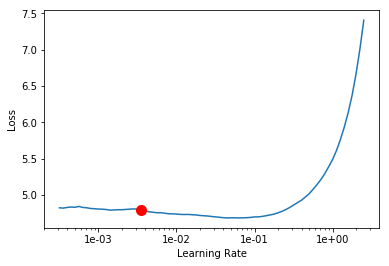

In [9]:
learn.recorder.plot(skip_end=10, suggestion=True)

In [10]:
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.0035481338923357537

In [11]:
%%time
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time


In [12]:
learn.unfreeze()

In [13]:
%%time
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.773828,3.687261,0.350675,17:25


CPU times: user 3min 56s, sys: 13min 36s, total: 17min 33s
Wall time: 17min 25s


# Generating some text

It's always interesting to see whether a LM is able to generate nice text. With LM training improvement (in terms of loss), at some point you'll notice some nice improvement in quality of the generated text.

One sample generated with my better-trained LM:

> 'An italian man was found dead in his yard due to heat conditions on Sunday night , his spokeswoman said . The office manager of the Ultra retired man ’s office told buzzfeed News there being no sign of comfort . The man at his 911 home told guy , he had been in contact with his car ’s owner before asleep and then immediately responded to starting fire . The man named Guy made a news video at PARKING Station in which the Mississippi State Police shot multiple people with Tim Shepherd to get their son alive , Mark Morris , a family friend dangling near his wife ’s house , said . The teen told police he was winning inclusion in general . Police dragged him into the house — where the officer had been yards away — during his die - hard bid at a nearby snow salon . The family voted in favor of Appreciative and arrested more than three months later : They tried to detained him . He and his family stopped , per the station , all the way up . “'

No much sense, but at least some structure :) And now with GPT-2 we see that quantitative improvements can also lead to qualital improvements.

In [14]:
learn.predict('An italian man was found dead in his yard due to', n_words=200)

'An italian man was found dead in his yard due to a migrant also was fatally stabbing a police officer in Charleston , South Carolina . He had been charged with crime and clashes for alleged stemming - obstruction and murder . They were released Monday in North Carolina and brought to the spread of racist anis for evacuation . a senior official at Eastern Theater will also confirm that Scott Scott was very young in Anaheim , Death Road . Rep. Cartier Smith ( d - Ill it would been ’ Jason Day , a Trump predecessor ) said even his two daughters were caught up in the accident . Martin Turner looks after the panic within afterwards and has taken credit for his families in Selma . Chad Thompson , a Volkswagen analyst from Tampa , Florida , decided to take a picture in another vehicle , where he found a boy telling the boy he was drunken at school his son , Jessie Joyce , died on 12 December 2016 . This resulted in'

In [15]:
learn.save_encoder('clickbait_news_enc')

# Training classification head

Here again we follow Jeremy Howard. 

**How to do better:** hyperparam tuning (though it's extremely annoying with such a heavy model), more epochs after unfreezing, check for some live examples of ULMFiT training, different learning rates for different layers etc.

In [16]:
train_file, test_file = 'train_28k.csv', 'test_5k.csv'

In [17]:
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=train_file,
                                        test=test_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=64,
                                        text_cols='text', 
                                        label_cols='label')

In [18]:
data_clas.save('ulmfit_data_clas_clickbait_news')

In [19]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)
learn_clas.load_encoder('clickbait_news_enc')

In [20]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.08E-04


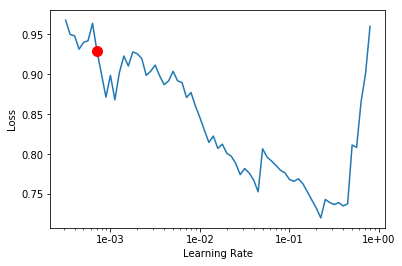

In [21]:
learn_clas.recorder.plot(skip_end=10, suggestion=True)

In [22]:
best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

0.0007079457843841381

In [23]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.560092,0.413709,0.856113,06:40


In [24]:
learn_clas.freeze_to(-2)

In [25]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.481818,0.319030,0.875638,06:59


In [26]:
learn_clas.unfreeze()

In [27]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.380593,0.300883,0.877221,11:54


In [28]:
learn_clas.show_results()

text,target,prediction
"xxbos xxmaj times reporters and editors provided coverage of the xxunk , xxmaj lady xxmaj gaga , and oh yeah , the football game as the xxmaj patriots rallied to defeat the xxmaj falcons in overtime , 34 - 28 . xxup feb . 5 , 2017 xxmaj andrew xxmaj das xxmaj editor xxunk xxup pm xxup et xxmaj welcome to our coverage of the xxmaj super xxmaj bowl .",news,news
"xxbos xxmaj the polls have closed in xxmaj georgia ’s xxmaj sixth xxmaj congressional district for the special election between xxmaj democrat xxmaj jon xxmaj ossoff and xxmaj republican xxmaj karen xxmaj handel . [ xxmaj the special election has turned out to be the most expensive in xxup u. xxup s. history , with each side pouring in tens of millions of dollars to back their particular candidate as",news,news
xxbos xxmaj serie a ’s reputation as a slow league for older players is outdated . xxmaj italian football is developing some of the world ’s most exciting players . xxmaj here are 50 of them xxmaj by xxmaj the xxmaj gentleman xxmaj ultra for the xxmaj guardian xxmaj sport xxmaj network xxmaj when xxmaj paul xxmaj pogba arrived at xxmaj juventus in 2012 he was a brash and raw,clickbait,news
"xxbos xxmaj on xxmaj march 22 , 2015 , xxmaj jay xxmaj wright knew the score . xxmaj the xxmaj villanova coach had just seen his xxmaj no . xxunk team fall to xxmaj no . 8 xxup nc xxmaj state , 71 - 68 , in xxmaj pittsburgh in the round of 32 . xxmaj wright had no doubts about how the rest of the world -- talking heads",clickbait,news
"xxbos xxmaj the confetti has n't even been swept from the floor in xxmaj phoenix , but it 's already time to start thinking about who will vie for the 2018 men 's basketball national championship in xxmaj san xxmaj antonio . xxmaj the only prediction guaranteed to come true in this super - early look at next year 's xxmaj top 25 is that in two months ' time",news,news


# Predictions for the test set

I'm doing it very inefficiently - one instance at a time

**How to do better:** in a mini-batch manner. 

In [29]:
%%time
test_preds = np.concatenate([learn_clas.predict(item=test.iloc[i])[2].cpu().numpy().reshape(1, -1)
                            for i in tqdm_notebook(range(len(test)))], axis=0)


CPU times: user 14min 32s, sys: 7min 47s, total: 22min 19s
Wall time: 22min 15s


# Forming a submission file

In [30]:
test_pred_df = pd.DataFrame(test_preds, columns=['clickbait', 'news', 'other'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'clickbait', 1: 'news', 2: 'other'})


In [31]:
ulmfit_preds.head()

0         news
1    clickbait
2         news
3    clickbait
4         news
Name: label, dtype: object

In [32]:
ulmfit_preds.to_csv('ulmfit_predictions.csv', index_label='id', header=True)